In [1]:
import pandas as pd
import numpy as np
import re
import string
from nltk.corpus import stopwords
from nltk.stem.snowball import SnowballStemmer
from nltk.tokenize import TweetTokenizer
from emot.emo_unicode import UNICODE_EMOJI
from vaderSentiment.vaderSentiment import SentimentIntensityAnalyzer
import matplotlib.pyplot as plt
import nltk
import gensim
from gensim import corpora
import pyLDAvis
import pyLDAvis.gensim_models as gensimvis
pyLDAvis.enable_notebook()
import matplotlib.pyplot as plt
import seaborn as sns
#nltk.download('punkt')
%matplotlib inline

In [2]:
team_tweets_df = pd.read_csv("Team_tweets.csv")
team_tweets_df.shape
team_tweets_df.head(10)

,Team,Date,Tweet
0,Boston Bruins,2022-03-02 18:35:00+00:00,Boston is well-known for the pivotal role it p...
1,Boston Bruins,2022-03-02 18:26:01+00:00,RT @BOSHockeyNow: COLUMN: While some fans may ...
2,Boston Bruins,2022-03-02 18:19:19+00:00,RT @hockeyfights: Nick Foligno vs Sam Carrick ...
3,Boston Bruins,2022-03-02 18:16:46+00:00,RT @olivecoverage: Are you ready for the game ...
4,Boston Bruins,2022-03-02 18:15:01+00:00,RT @NHLdotcom: Trevor Zegras scored a power-pl...
5,Boston Bruins,2022-03-02 18:14:40+00:00,RT @FlyersAlumni: Today in Flyers History: On...
6,Boston Bruins,2022-03-02 18:10:44+00:00,RT @NHLdotcom: Trevor Zegras scored a power-pl...
7,Boston Bruins,2022-03-02 18:10:01+00:00,Nick Foligno Happy His Game ‘Gearing Up’ At Ri...
8,Boston Bruins,2022-03-02 18:07:24+00:00,To all the Jake DeBrusk fans out there its ove...
9,Boston Bruins,2022-03-02 18:06:17+00:00,"The Bruins self-inflicted in the first, bounce..."


# Tweets cleaning

In [3]:
#removing hyoerlinks
team_tweets_df["Tweet"] = team_tweets_df["Tweet"].str.replace(r'https?:\/\/.*[\r\n]*', ' ').str.strip()

#remove # and @ from tweets
team_tweets_df["Tweet"] = team_tweets_df["Tweet"].str.replace(r'@\w+|#\w+', ' ').str.strip()

/var/folders/sf/sxg31ljs3ks0h1bsflmz2z1c0000gn/T/ipykernel_99543/2638728161.py:2: FutureWarning: The default value of regex will change from True to False in a future version.
  team_tweets_df["Tweet"] = team_tweets_df["Tweet"].str.replace(r'https?:\/\/.*[\r\n]*', ' ').str.strip()
/var/folders/sf/sxg31ljs3ks0h1bsflmz2z1c0000gn/T/ipykernel_99543/2638728161.py:5: FutureWarning: The default value of regex will change from True to False in a future version.
  team_tweets_df["Tweet"] = team_tweets_df["Tweet"].str.replace(r'@\w+|#\w+', ' ').str.strip()


In [4]:
#remove punctuation
team_tweets_df["Tweet"] = team_tweets_df["Tweet"].str.replace('[{}]'.format(string.punctuation), '')


/var/folders/sf/sxg31ljs3ks0h1bsflmz2z1c0000gn/T/ipykernel_99543/4130564778.py:2: FutureWarning: The default value of regex will change from True to False in a future version.
  team_tweets_df["Tweet"] = team_tweets_df["Tweet"].str.replace('[{}]'.format(string.punctuation), '')


In [5]:
# Function for converting emojis into word
def handle_emojis(tweet):
    for emot in UNICODE_EMOJI:
        tweet = tweet.replace(emot, (" " + "_".join(UNICODE_EMOJI[emot].replace(",","").replace(":","").split())))
    return tweet

team_tweets_df["Tweet"] = team_tweets_df["Tweet"].apply(handle_emojis)

# Sentiment Stats of each team

In [6]:
team_names = team_tweets_df["Team"].unique()
analyzer = SentimentIntensityAnalyzer()
pd.options.mode.chained_assignment = None

Team_arr = []
positive_scores = []
negative_scores = []
neutral_scores = []

def determine_polarity(tweet):
    pol_scores = analyzer.polarity_scores(tweet) 
    compound_score = pol_scores["compound"]
    if compound_score >= 0.005:
        return "positive"
    elif compound_score <= -0.005:
        return "negative"
    else:
        return "neutral"
    
for team in team_names:
    curr_team_df = team_tweets_df.loc[team_tweets_df["Team"] == team]
    curr_team_df["polarity"] = curr_team_df["Tweet"].apply(determine_polarity)
    
    pos_num = curr_team_df[curr_team_df["polarity"]== "positive"].count()["Tweet"]
    neg_num = curr_team_df[curr_team_df["polarity"]== "negative"].count()["Tweet"]
    neu_num = curr_team_df[curr_team_df["polarity"]== "neutral"].count()["Tweet"]
    
    Team_arr.append(team)
    positive_scores.append(pos_num)
    negative_scores.append(neg_num)
    neutral_scores.append(neu_num)
    
    print("\n=========== ",team ," Tweets Sentiment Stats: =================")
    print("Positive Tweets: ", pos_num)
    print("Negative Tweets: ", neg_num)
    print("Neutral Tweets:  ", neu_num)

Team_sentiment_stats_df = pd.DataFrame({"Team" : Team_arr,
                              "Positive_tweet" : positive_scores,
                              "Negative_tweet" : negative_scores,
                              "Neutral_tweet" : neutral_scores
                                       })
print(Team_sentiment_stats_df)


===========  Boston Bruins  Tweets Sentiment Stats: =================
Positive Tweets:  257
Negative Tweets:  72
Neutral Tweets:   171

===========  Buffalo Sabres  Tweets Sentiment Stats: =================
Positive Tweets:  214
Negative Tweets:  87
Neutral Tweets:   199

===========  Detroit Red Wings  Tweets Sentiment Stats: =================
Positive Tweets:  205
Negative Tweets:  53
Neutral Tweets:   242

===========  Florida Panthers  Tweets Sentiment Stats: =================
Positive Tweets:  295
Negative Tweets:  35
Neutral Tweets:   170

===========  Montreal Canadiens  Tweets Sentiment Stats: =================
Positive Tweets:  109
Negative Tweets:  177
Neutral Tweets:   214

===========  Ottawa Senators  Tweets Sentiment Stats: =================
Positive Tweets:  250
Negative Tweets:  65
Neutral Tweets:   185

===========  Tampa Bay Lightning  Tweets Sentiment Stats: =================
Positive Tweets:  218
Negative Tweets:  68
Neutral Tweets:   214

===========  Toronto Mapl

[ 0.       0.96875  1.9375   2.90625  3.875    4.84375  5.8125   6.78125
  7.75     8.71875  9.6875  10.65625 11.625   12.59375 13.5625  14.53125
 15.5     16.46875 17.4375  18.40625 19.375   20.34375 21.3125  22.28125
 23.25    24.21875 25.1875  26.15625 27.125   28.09375 29.0625  30.03125
 31.     ]


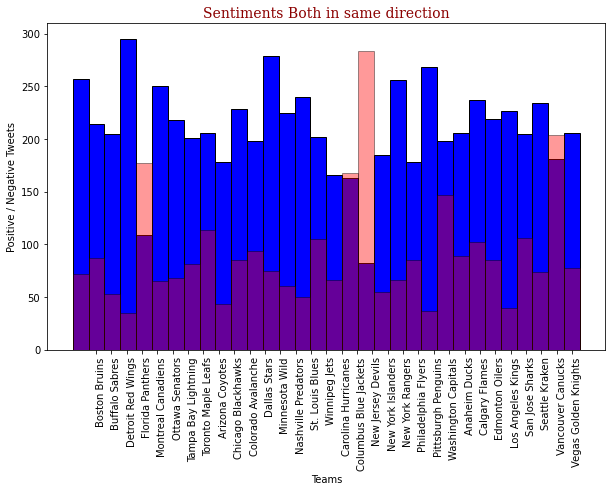

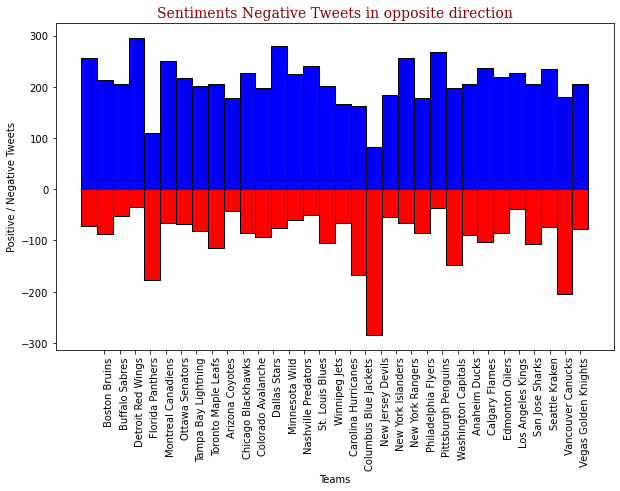

In [8]:
font = {'family': 'serif',
        'color':  'darkred',
        'weight': 'normal',
        'size': 14,
        }

team_total = range(32)
fig = plt.figure(figsize = (10,6))
ax = plt.subplot(111)
plt.xlabel('Teams')
plt.ylabel('Positive / Negative Tweets')

#print(len(Team_sentiment_stats_df["Positive_tweet"].tolist()))
#print(len(Team_sentiment_stats_df["Team"].tolist()))
#print(len(Team_sentiment_stats_df["Negative_tweet"].tolist()))

n, bins, patches = plt.hist(Team_sentiment_stats_df["Team"].tolist(), Team_sentiment_stats_df["Team"].unique().__len__(), stacked=True, density=False)
plt.title("Sentiments Both in same direction", fontdict= font, loc='center')
#print(bins)
plt.xticks(ticks = bins[1:], labels = Team_sentiment_stats_df["Team"], rotation = 90, horizontalalignment = 'left')
ax.bar(team_total, Team_sentiment_stats_df["Positive_tweet"].tolist(), width=1,alpha=1, color='b',facecolor='blue', edgecolor='black')
ax.bar(team_total, Team_sentiment_stats_df["Negative_tweet"].tolist(), width=1, alpha=0.4,color='r',facecolor='red', edgecolor='black')
plt.show()
#plt.hist(x, density=False)  # density=False would make counts
#plt.ylabel('Probability')
#plt.xlabel('Data')

fig = plt.figure(figsize = (10,6))
ax = plt.subplot(111)
plt.xlabel('Teams')
plt.ylabel('Positive / Negative Tweets')

n, bins, patches = plt.hist(Team_sentiment_stats_df["Team"].tolist(), Team_sentiment_stats_df["Team"].unique().__len__(), stacked=True, density=False)
negative_data_opposite = [i * -1 for i in Team_sentiment_stats_df["Negative_tweet"].tolist()]

plt.xticks(ticks=bins[1:], labels=Team_sentiment_stats_df["Team"], rotation=90, horizontalalignment='left')
plt.title("Sentiments Negative Tweets in opposite direction", fontdict= font, loc='center')
ax.bar(team_total, Team_sentiment_stats_df["Positive_tweet"].tolist(), width=1, color='b',facecolor='blue', edgecolor='black')
ax.bar(team_total, negative_data_opposite, alpha=1, width=1, color='r', facecolor='red', edgecolor='black')

plt.show()

In [ ]:
#testing
"""
pos_tweets = [('I love this you car @hello', 'positive'),
    ('This view is amazing', 'positive'),
    ('I feel great this morning', 'positive'),
    ('I am so excited #1234 about the concert', 'positive'),
    ('He is my best friend', 'positive')]

test = pd.DataFrame(pos_tweets)
test.columns = ["tweet","class"]

test['tweet'] = test['tweet'].apply(stop_word_removal)
print(test)
"""

# Topic Modelling

In [9]:
#remove stop words

stop_wrds = stopwords.words('english')

def stop_word_removal(tweet):
    return ' '.join([word for word in tweet.split() if word not in stop_wrds])

team_tweets_df["Tweet"] = team_tweets_df["Tweet"].apply(stop_word_removal)

In [10]:
#tokenization and stemming
##need to change it to lemmatization
tokenizer = TweetTokenizer(
    preserve_case=False,
    strip_handles=True,
    reduce_len=True)

snowball_stemmer = SnowballStemmer("english")

def tokenization_stemming(tweet):
    sentence_token_stem = []
    token_sent = tokenizer.tokenize(tweet)
    for token in token_sent:
        sentence_token_stem.append(snowball_stemmer.stem(token))
    return sentence_token_stem

team_tweets_df["Tweet"] = team_tweets_df["Tweet"].apply(tokenization_stemming)
team_tweets_df.to_csv('check.csv', index = False)

In [11]:
#LDA Topic Modelling
#needs improvement
sample_team_df =  team_tweets_df.loc[team_tweets_df["Team"] == "Boston Bruins"]
tokenized_tweets = sample_team_df["Tweet"].tolist()
dictionary = corpora.Dictionary(tokenized_tweets)
doc_term_matrix = [dictionary.doc2bow(rev) for rev in tokenized_tweets]


LDA = gensim.models.ldamodel.LdaModel

lda_model = LDA(corpus=doc_term_matrix, id2word=dictionary, num_topics=3, random_state=100, chunksize=100, passes=50,iterations=100) 


In [12]:
pyLDAvis.enable_notebook()
vis = gensimvis.prepare(lda_model, doc_term_matrix, dictionary)
vis 

/Users/priyankamanam/opt/anaconda3/lib/python3.9/site-packages/pyLDAvis/_prepare.py:246: FutureWarning: In a future version of pandas all arguments of DataFrame.drop except for the argument 'labels' will be keyword-only
  default_term_info = default_term_info.sort_values(
/Users/priyankamanam/opt/anaconda3/lib/python3.9/site-packages/past/builtins/misc.py:45: DeprecationWarning: the imp module is deprecated in favour of importlib; see the module's documentation for alternative uses
  from imp import reload
/Users/priyankamanam/opt/anaconda3/lib/python3.9/site-packages/past/builtins/misc.py:45: DeprecationWarning: the imp module is deprecated in favour of importlib; see the module's documentation for alternative uses
  from imp import reload
/Users/priyankamanam/opt/anaconda3/lib/python3.9/site-packages/past/builtins/misc.py:45: DeprecationWarning: the imp module is deprecated in favour of importlib; see the module's documentation for alternative uses
  from imp import reload
/Users/pri

PreparedData(topic_coordinates=              x         y  topics  cluster       Freq
topic                                                
2      0.120857  0.123073       1        1  38.669558
1     -0.172966  0.037593       2        1  31.773494
0      0.052108 -0.160666       3        1  29.556948, topic_info=         Term       Freq       Total Category  logprob  loglift
36       duck  86.000000   86.000000  Default  30.0000  30.0000
93      first  39.000000   39.000000  Default  29.0000  29.0000
80     season  38.000000   38.000000  Default  28.0000  28.0000
310  februari  37.000000   37.000000  Default  27.0000  27.0000
195   swayman  36.000000   36.000000  Default  26.0000  26.0000
..        ...        ...         ...      ...      ...      ...
31          …  35.944028  107.770615   Topic3  -4.1630   0.1208
84          ’  23.066862   56.481414   Topic3  -4.6066   0.3233
25         rt  30.429556  127.937487   Topic3  -4.3295  -0.2173
69      march  11.885347   18.256227   Topic3  -5.2696   0.7897
100       the  11.676563   66.551163   Topic3  -5.2874  -0.5215

[169 rows x 6 columns], token_table=      Topic      Freq  Term
term                       
584       3  0.945605  1970
532       3  0.943166   1st
65        2  0.134638     2
65        3  0.852705     2
33        1  0.959010  2022
...     ...       ...   ...
84        3  0.407214     ’
1140      2  0.971535     ”
31        1  0.296927     …
31        2  0.371159     …
31        3  0.334043     …

[169 rows x 3 columns], R=30, lambda_step=0.01, plot_opts={'xlab': 'PC1', 'ylab': 'PC2'}, topic_order=[3, 2, 1])